<a href="https://colab.research.google.com/github/Said20038/DeepLearning/blob/main/LeNet5_avec_RGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#General Introduction
Handwritten character recognition is a key area of artificial intelligence, with major applications in natural language processing (NLP) and optical character recognition (OCR). It allows for the preservation and digitization of historical and cultural scripts, thus facilitating their study and dissemination. Among these scripts, the Amazigh alphabet, used by Berber populations across the Maghreb, is of significant cultural importance, but its automatic recognition remains a challenge due to the variability of handwriting styles. This practical work addresses this issue by exploring the use of a convolutional neural network (CNN), based on the classic LeNet-5 architecture, to classify Amazigh handwritten characters from the Amazigh Handwritten Character Database (AMHCD) dataset. The objective is to evaluate the performance of this model, analyze its limitations, and lay the foundations for future integration into dedicated OCR systems. Through this practical work, we will implement the steps of data preprocessing, model design and training, as well as the interpretation of quantitative and qualitative results.

In [ ]:
# 1. Installer les dépendances
!pip install -q kagglehub scikit-learn

# 2. Upload du fichier kaggle.json
from google.colab import files
files.upload()  # Choisir kaggle.json

# 3. Configurer l’environnement Kaggle
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

# 4. Télécharger le dataset via kagglehub
import kagglehub

path = kagglehub.dataset_download("benaddym/amazigh-handwritten-character-database-amhcd")
print(" Dataset téléchargé dans :", path)


Saving kaggle.json to kaggle.json
 Dataset téléchargé dans : /kaggle/input/amazigh-handwritten-character-database-amhcd


In [ ]:
# 5. Charger les images RGB
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import os

IMG_SIZE = 32
# Corrected path to the nested AMHCD_64 directory containing class folders
DATA_DIR = os.path.join(path, "AMHCD_64", "AMHCD_64")

def load_data_rgb(data_dir):
    images, labels = [], []
    # List the contents of the DATA_DIR (which should contain the class folders)
    # Filter for directories - these are the actual class folders
    class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

    print(f"Identified class directories: {class_names[:5]}... ({len(class_names)} classes)") # Print only first 5 for brevity

    if not class_names:
        print(f"Error: No class directories found in {data_dir}")
        return np.array([]), np.array([]), [] # Return empty arrays and list if no classes found


    for idx, class_name in enumerate(class_names):
        folder_path = os.path.join(data_dir, class_name)
        # Iterate through the files in each class folder
        for img_name in tqdm(os.listdir(folder_path), desc=f"Loading class {class_name}"):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:  # Check if image loaded successfully
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                images.append(img)
                labels.append(idx)
    return np.array(images), np.array(labels), class_names

images, labels, class_names = load_data_rgb(DATA_DIR)

if len(images) > 0: # Only proceed if images were loaded
    images = images.astype('float32') / 255.0

    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
    y_train = to_categorical(y_train, num_classes=len(class_names))
    y_test = to_categorical(y_test, num_classes=len(class_names))

    print(f"Données loaded : {len(images)} images, {len(class_names)} classes") # Corrected print statement
else:
    print(" No images were loaded. Cannot perform train/test split.")

Identified class directories: ['ya', 'yab', 'yach', 'yad', 'yadd']... (33 classes)


Loading class yu: 100%|██████████| 780/780 [00:03<00:00, 198.49it/s]


Données loaded : 25740 images, 33 classes


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense

def create_lenet5(input_shape, num_classes):
    model = Sequential([
        Conv2D(6, kernel_size=5, activation='tanh', padding='same', input_shape=input_shape),
        AveragePooling2D(pool_size=(2, 2)), # Added pool_size
        Conv2D(16, kernel_size=5, activation='tanh'),
        AveragePooling2D(pool_size=(2, 2)), # Added pool_size
        Flatten(),
        Dense(120, activation='tanh'),
        Dense(84, activation='tanh'),
        Dense(num_classes, activation='softmax')
    ])
    return model

model = create_lenet5((IMG_SIZE, IMG_SIZE, 3), len(class_names))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 6)      │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 16, 16, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 6, 6, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │        69,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 33)             │         2,805 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,081 (332.35 KB)

 Trainable params: 85,081 (332.35 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    verbose=2
)


Epoch 1/20
290/290 - 20s - 70ms/step - accuracy: 0.5564 - loss: 1.7787 - val_accuracy: 0.8578 - val_loss: 0.6253
Epoch 2/20
290/290 - 14s - 49ms/step - accuracy: 0.8976 - loss: 0.4335 - val_accuracy: 0.9053 - val_loss: 0.3646
Epoch 3/20
290/290 - 24s - 82ms/step - accuracy: 0.9275 - loss: 0.2870 - val_accuracy: 0.9228 - val_loss: 0.2831
Epoch 4/20
290/290 - 17s - 59ms/step - accuracy: 0.9467 - loss: 0.2122 - val_accuracy: 0.9364 - val_loss: 0.2501
Epoch 5/20
290/290 - 15s - 51ms/step - accuracy: 0.9580 - loss: 0.1655 - val_accuracy: 0.9417 - val_loss: 0.2090
Epoch 6/20
290/290 - 21s - 71ms/step - accuracy: 0.9671 - loss: 0.1306 - val_accuracy: 0.9447 - val_loss: 0.2064
Epoch 7/20
290/290 - 15s - 52ms/step - accuracy: 0.9749 - loss: 0.1038 - val_accuracy: 0.9553 - val_loss: 0.1687
Epoch 8/20
290/290 - 20s - 70ms/step - accuracy: 0.9803 - loss: 0.0836 - val_accuracy: 0.9558 - val_loss: 0.1618
Epoch 9/20
290/290 - 20s - 69ms/step - accuracy: 0.9846 - loss: 0.0651 - val_accuracy: 0.9568 - 

161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
Rapport de classification :

              precision    recall  f1-score   support

          ya       0.99      1.00      1.00       151
         yab       0.98      1.00      0.99       145
        yach       0.96      0.93      0.95       152
         yad       0.98      1.00      0.99       164
        yadd       0.96      0.95      0.96       175
         yae       0.99      0.99      0.99       161
         yaf       0.99      0.97      0.98       150
         yag       0.97      0.97      0.97       157
        yagh       0.98      0.99      0.99       163
        yagw       0.96      0.97      0.96       141
         yah       0.99      0.98      0.98       164
        yahh       0.96      0.98      0.97       162
         yaj       0.99      0.98      0.99       173
         yak       0.97      0.92      0.94       159
        yakw       0.92      0.97      0.95       153
         yal       0.99      0.96      0.97       156
         y

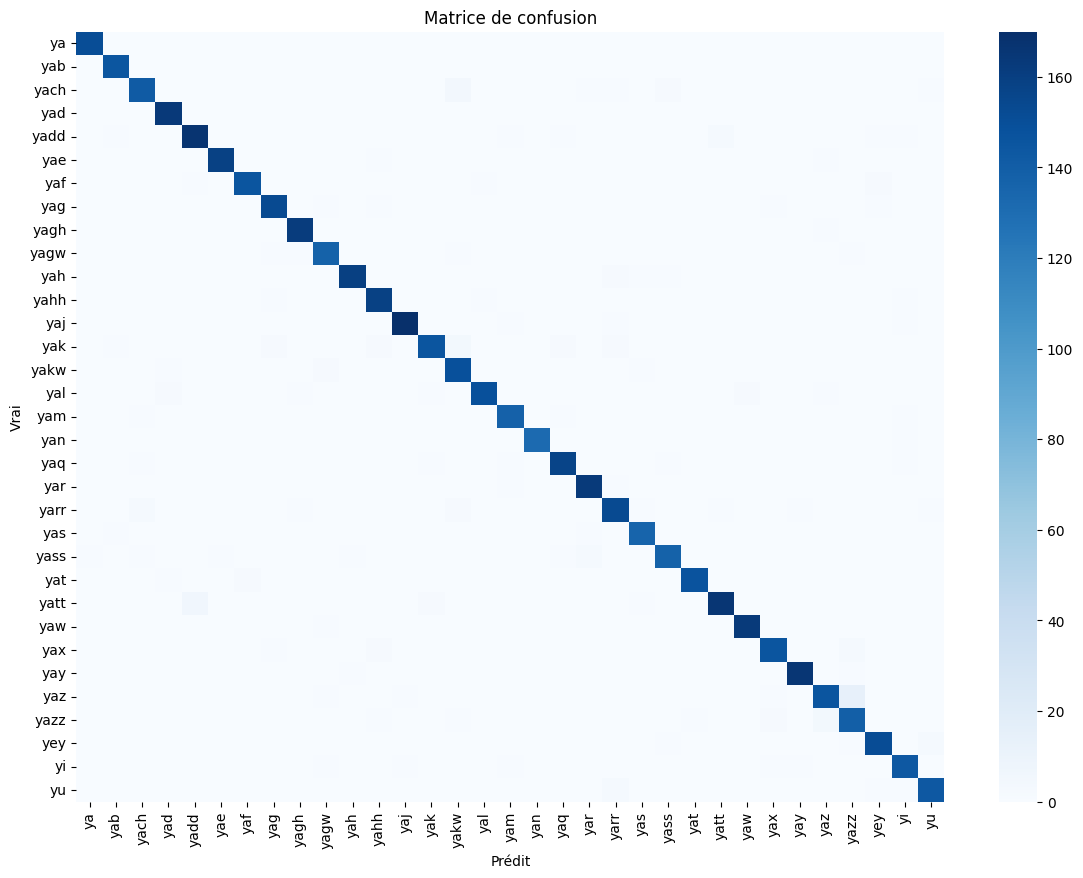

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Prédictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification Report (F1-score etc.)
print("Rapport de classification :\n")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Matrice de confusion")
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.show()


161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step


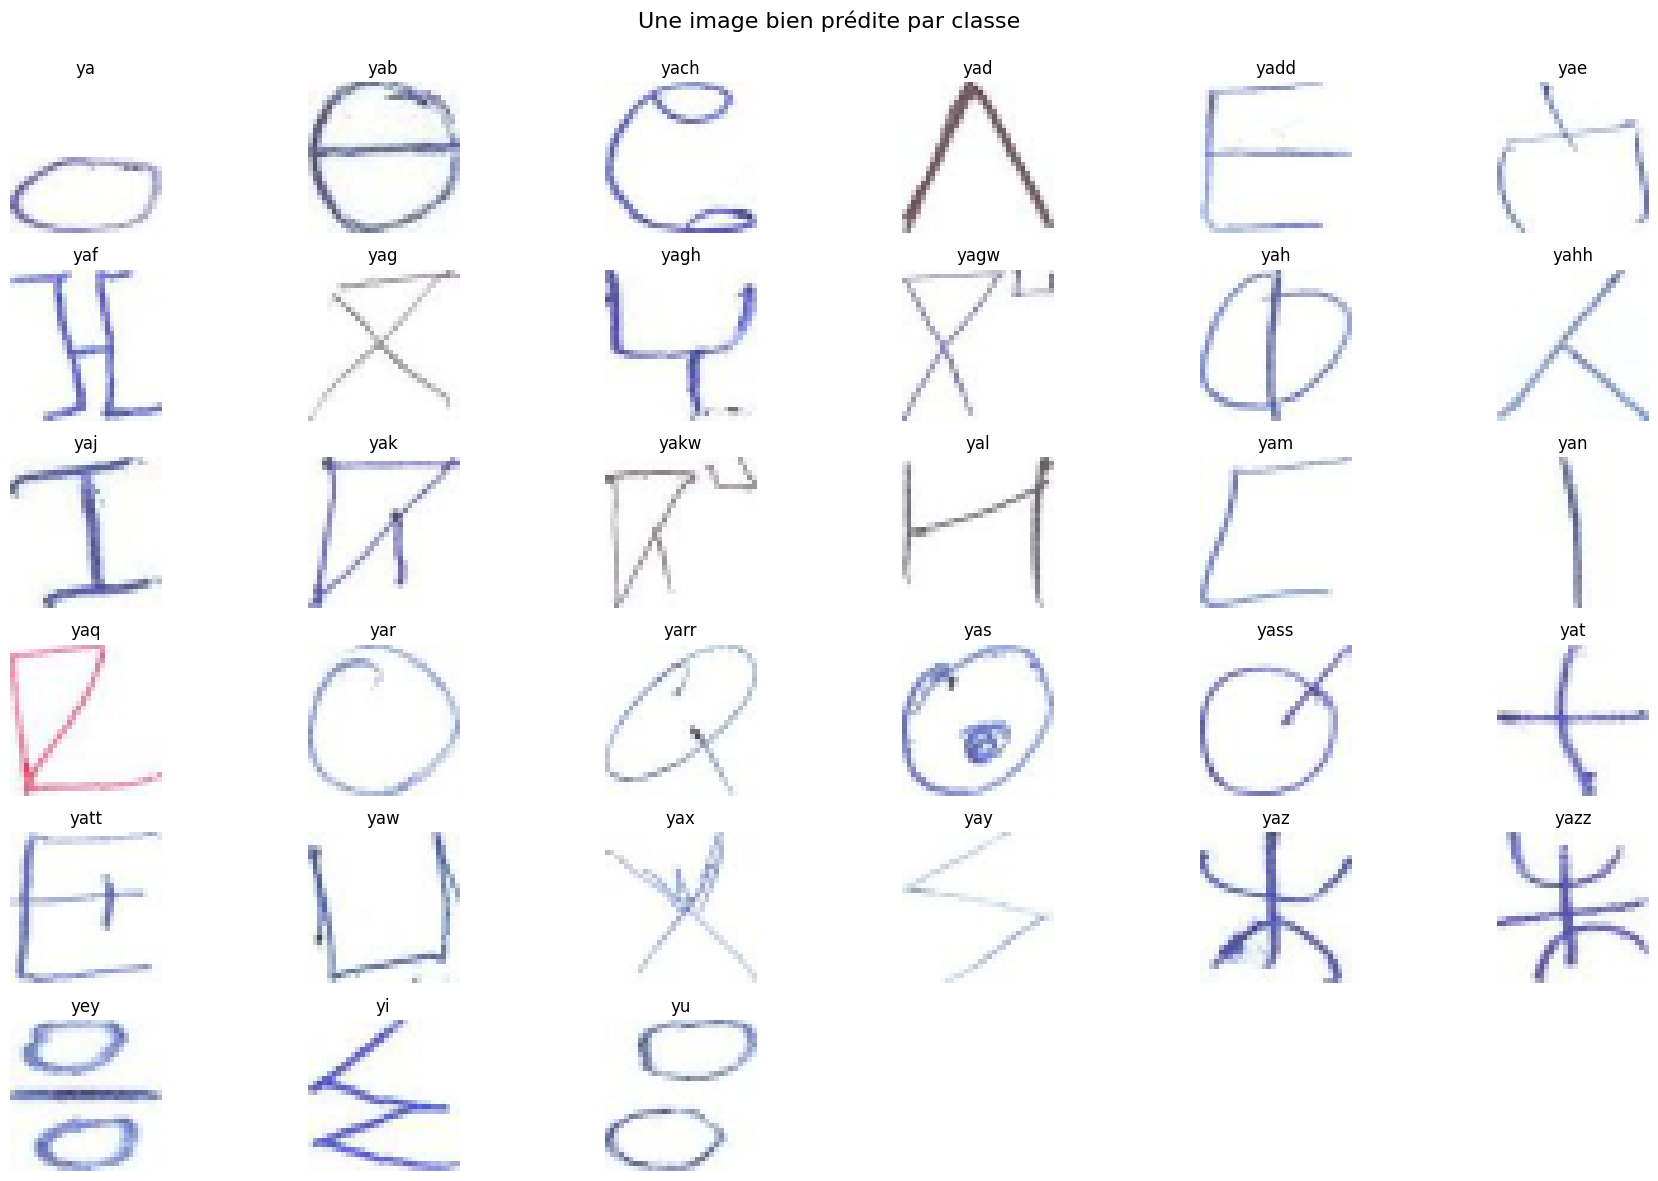

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Convertir les prédictions du modèle
y_pred_classes = np.argmax(model.predict(X_test), axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Dictionnaire pour stocker une bonne prédiction par classe
correctly_predicted = {}

# Parcourir toutes les prédictions
for i in range(len(X_test)):
    true_label = y_true_classes[i]
    pred_label = y_pred_classes[i]

    # Si la prédiction est correcte et qu'on n'a pas encore stocké cette classe
    if true_label == pred_label and true_label not in correctly_predicted:
        correctly_predicted[true_label] = i

    # Stop si on a trouvé une image correcte pour chaque classe
    if len(correctly_predicted) == len(class_names):
        break

# Affichage
plt.figure(figsize=(18, 12))

for class_idx, image_idx in correctly_predicted.items():
    image = X_test[image_idx]

    # Reconvertir [0,1] → [0,255] et BGR → RGB
    img_rgb = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_BGR2RGB)

    ax = plt.subplot(6, 6, class_idx + 1)
    plt.imshow(img_rgb)
    plt.axis('off')
    ax.set_title(class_names[class_idx], fontsize=12)

plt.suptitle("Une image bien prédite par classe", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()
